## Week8 - Task 5

You are trying to discover the number of people who have had a disease in a population of 1 million
people.
Antibody tests can reveal who has had the disease but the tests are not perfect.
To evaluate the tests, 85 people who were known to have had the disease are tested and 78 are found
to test positive. 371 people who have definitely not had the disease are also tested and 2 test positive.
In the full survey, 3439 people are tested and 50 test positive for the antibodies.
Use HMC sampling to create a posterior distribution of the total number of people in the population that
have been infected given these data.
Make sure to incorporate into the statistical model the false positive rate and the true positive rate of the
tests. Assume a uniform prior for these rates and the population prevalence.

We’ll use a joint distribution to set up the model so that the uncertainty in the accuracy of the test
is included. There are 3 parameters of the distribution, the true positive rate of the test, the false positive rate of the
test, and population prevalence. Given these 3 parameters we can calculate the log likelihood of the observed data.

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions

In [2]:
known_positive=85
true_positive=78
known_negative=371
false_positive=2
num_tested=3439
num_positive=50

In [10]:
def log_prevalence(tp_rate,fp_rate, prevalence):
    jd = tfd.JointDistributionSequential([
        tfd.Binomial(known_positive,probs=tp_rate),
        tfd.Binomial(known_negative,probs=fp_rate),
        tfd.Binomial(num_tested,probs=fp_rate * (1 - prevalence) + tp_rate * prevalence)
    ])
    
    return jd.log_prob([true_positive,false_positive,num_positive])

Now we have a function for the log likelihood of the data given the 3 parameters of our model we can sample from
the posterior distribution.

In [12]:
@tf.function
def run_hmc_sampler():
    # setup the inner kernel
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(log_prevalence,
                                                step_size=0.05,
                                                num_leapfrog_steps=10)
    # setup a transform kernel to keep parameters in 0,1
    kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel,
                                                    bijector=[tfp.bijectors.Sigmoid(),
                                                        tfp.bijectors.Sigmoid(),
                                                        tfp.bijectors.Sigmoid()])
                                                    
    samples, kernels_results = tfp.mcmc.sample_chain(num_results=2000,
                                                    current_state=[0.5,0.5,0.5],
                                                    num_steps_between_results=2,
                                                    kernel=kernel,
                                                    num_burnin_steps=500)
    return samples

# run the sampler.
s_hmc = run_hmc_sampler()

/opt/conda/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:70: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(
2023-07-28 14:17:07.466604: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 14:17:08.055228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28 MB memory:  -> device: 0, name: Tesla M60, pci bus id: 0001:00:00.0, compute capability: 5.2


/opt/conda/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [13]:
#We can now plot the posterior distribution for the test characteristic parameters and the population prevalence.

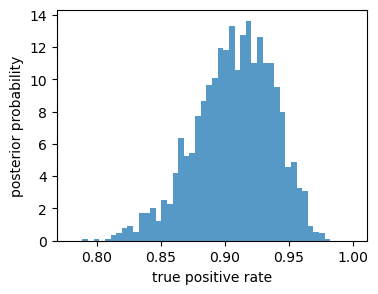

In [14]:
plt.figure(figsize=(4,3))
plt.hist(s_hmc[0].numpy(),bins=50,range=(0.78,1),density=True,alpha=0.75)
plt.xlabel('true positive rate')
plt.ylabel('posterior probability')
plt.show()

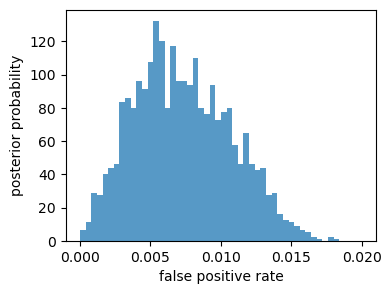

In [15]:
plt.figure(figsize=(4,3))
plt.hist(s_hmc[1].numpy(),bins=50,range=(0,0.02),density=True,alpha=0.75)
plt.xlabel('false positive rate')
plt.ylabel('posterior probability')
plt.show()

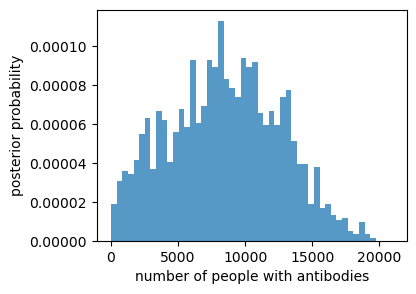

In [16]:
plt.figure(figsize=(4,3))
# multiply prevalence by population size (1million) to get number infected
plt.hist(1e6*s_hmc[2].numpy(),bins=50,range=(0,1e6*0.021),density=True,alpha=0.75)
plt.xlabel('number of people with antibodies')
plt.ylabel('posterior probability')
plt.show()